In [1]:
# imports
from sqlalchemy import create_engine, Column, String, Integer, Float, Date, MetaData, Table, type_coerce, between
from sqlalchemy import case
from sqlalchemy.orm import mapper, create_session
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.sql import and_, or_, not_, func
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import os
import re
from mpl_toolkits.basemap import Basemap
import pandas as pd
import datetime as dt
%matplotlib inline

/home/eolson/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/eolson/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# definitions
basepath='/ocean/eolson/MEOPAR/obs/'
hdir='ECRivers'
dbname='ECRiversDB'
dbpath=os.path.join(basepath,hdir,dbname)
print(dbpath)

/ocean/eolson/MEOPAR/obs/ECRivers/ECRiversDB


In [3]:
engine = create_engine('sqlite:///'+dbpath+'.sqlite')

In [4]:
Base = automap_base()
# reflect the tables in salish.sqlite:
Base.prepare(engine, reflect=True)
# mapped classes have been created
Profs=Base.classes.profiles
PDates=Base.classes.ProfDateMatchTBL
Flow=Base.classes.FlowTBL
session = create_session(bind = engine, autocommit = False, autoflush = True)


In [5]:
# display turbidity variable:
data=session.query(Profs.variable_name).group_by(Profs.variable_name).filter(Profs.variable_name.startswith('TUR')).all()
for row in data:
    print(row)

('TURBIDITY',)


(49.167, -123.035, 'Fraser River (Main Arm) at Gravesend Reach - Buoy', 6467)
(49.38722, -121.4508, 'Fraser River at Hope', 30325)
(49.24211, -122.5961, 'North Alouette River at 132nd Ave and Edge Street', 18431)


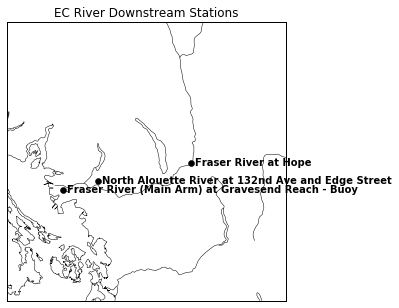

In [6]:
# interested in 2 stations: Hope & Gravesend; don't want Alouette R at 132nd
data=session.query(Profs.latitude, Profs.longitude, Profs.station_name, func.count()).\
            filter(or_(Profs.station_name.like('%Hope%'),Profs.station_name.like('%132nd Ave and Edge Street%'),
                    Profs.station_name.like('%Gravesend%'))).group_by(Profs.station_name).all()
for row in data:
    print(row)

# map:
width = 250000; lon_0 = -122; lat_0 = 49.4
plt.figure(figsize=(5,5))
m = Basemap(width=width,height=width,projection='aeqd', resolution='h',lat_0=lat_0,lon_0=lon_0)
m.drawmapboundary()
m.drawcoastlines(linewidth=0.5)
m.drawrivers()
plt.title('EC River Downstream Stations')
for lat, lon, name, num in data:
    if lon>0:
        lon=-lon
    xpt, ypt = m(lon, lat)
    xpt2, ypt2 = m(lon+.05, lat)
    m.plot([xpt],[ypt],'ko')
    plt.text(xpt2,ypt2,name,fontsize=10,fontweight='bold',ha='left',va='center',color='k')

In [7]:
# count turbidity stations at each loc
data=session.query(Profs.latitude, Profs.longitude, Profs.station_name, func.count()).\
            filter(and_(or_(Profs.station_name.like('%Hope%'),Profs.station_name.like('%Gravesend%')), 
                        Profs.variable_name.startswith('TUR'))).\
    group_by(Profs.station_name).all()
for row in data:
    print(row)

(49.167, -123.035, 'Fraser River (Main Arm) at Gravesend Reach - Buoy', 85)
(49.38722, -121.4508, 'Fraser River at Hope', 736)


(733316.0, 735234.0)

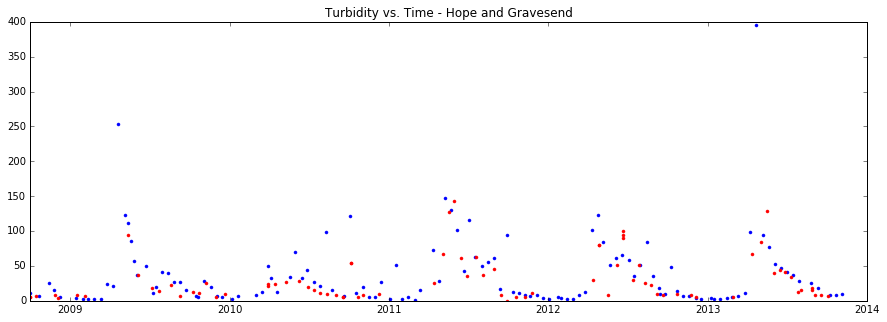

In [8]:
# plot timeseries together
data=session.query(Profs.Year, Profs.Month, Profs.Day, Profs.value).\
            filter(and_(Profs.variable_name=='TURBIDITY',
                Profs.station_name=='Fraser River (Main Arm) at Gravesend Reach - Buoy')).all()
Amm=[]
date=[]
for Y0, M0, D0, Amm0 in data:
    Amm.append(Amm0)
    date.append(dt.date(Y0,M0,D0))
AmmG=np.array(Amm)
dateG=np.array(date)

data=session.query(Profs.Year, Profs.Month, Profs.Day, Profs.value).\
            filter(and_(Profs.variable_name=='TURBIDITY',Profs.station_name.like('%Hope%'))).all()
Amm=[]
date=[]
for Y0, M0, D0, Amm0 in data:
    Amm.append(Amm0)
    date.append(dt.date(Y0,M0,D0))
AmmH=np.array(Amm)
dateH=np.array(date)

plt.figure(figsize=(15,5))
plt.plot(dateH, AmmH, 'b.')
plt.plot(dateG, AmmG, 'r.')
plt.title('Turbidity vs. Time - Hope and Gravesend')
plt.xlim((dt.date(2008,10,1),dt.date(2014,1,1)))


In [9]:
# try matching up Hope and Gravesend (to test lagged correlatoins): only 4 matches, so just use Hope data

# subquery all Hope values:
turH=session.query(PDates.NDate.label('Days'),Profs.value.label('TurH')).\
    select_from(Profs).join(PDates,PDates.ID==Profs.id).\
    filter(and_(Profs.variable_name=='TURBIDITY',Profs.station_name.like('%Hope%'))).subquery()

# subquery all Gravesend values:
turG=session.query(PDates.NDate.label('Days'),Profs.value.label('TurG')).\
    select_from(Profs).join(PDates,PDates.ID==Profs.id).\
    filter(and_(Profs.variable_name=='TURBIDITY',
                Profs.station_name=='Fraser River (Main Arm) at Gravesend Reach - Buoy')).subquery()
    
matchqry0=session.query(turH.c.TurH,turG.c.TurG).select_from(turH).join(turG,turG.c.Days==turH.c.Days)
print(matchqry0.count())

4


In [10]:
# use hope data. check that data are unique:
data=session.query(Profs.latitude, Profs.longitude, Profs.station_name).\
            filter(and_(Profs.station_name.like('%Hope%'), 
                        Profs.variable_name.startswith('TUR'),
                        Profs.value!=None,
                        Profs.value>-9))
print(data.count())
data=session.query(Profs.latitude, Profs.longitude, Profs.station_name,func.count()).\
            filter(and_(Profs.station_name.like('%Hope%'), 
                        Profs.variable_name.startswith('TUR'),
                        Profs.value!=None,
                        Profs.value>-9)).\
    group_by(Profs.Year,Profs.Month,Profs.Day)
print(data.count())
#for row in data:
#    print(row)

736
734


(722450.0, 735234.0)

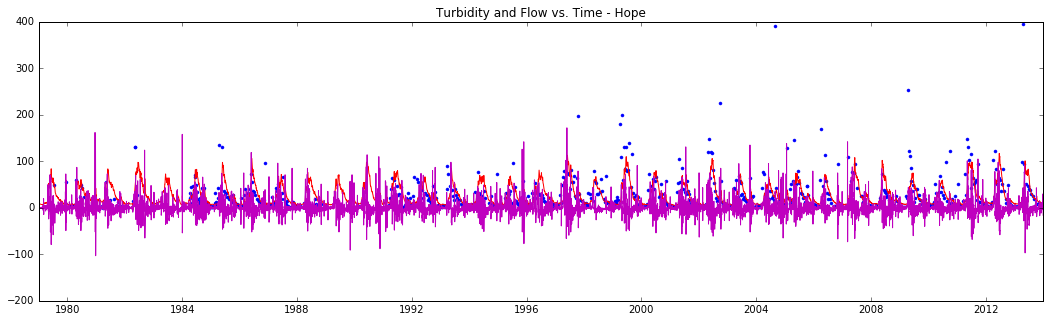

In [11]:
# plot flow and turbidity together
data=session.query(Profs.Year, Profs.Month, Profs.Day, Profs.value).\
            filter(and_(Profs.variable_name=='TURBIDITY',Profs.station_name.like('%Hope%'))).all()
Amm=[]
date=[]
for Y0, M0, D0, Amm0 in data:
    Amm.append(Amm0)
    date.append(dt.date(Y0,M0,D0))
AmmH=np.array(Amm)
dateH=np.array(date)

date=[]
fl=[]
daten0=[]
data2=session.query(Flow.Year,Flow.Month,Flow.Day,Flow.RateHope)
for row in data2.all():
    fl.append(row.RateHope)
    date.append(dt.date(row.Year,row.Month,row.Day))
    daten0.append((dt.date(row.Year,row.Month,row.Day)-dt.date(1900,1,1)).days)
FlowH=np.array(fl)
dateN=np.array(daten0)
dateF=np.array(date)
dFdt=np.diff(FlowH)/np.diff(dateN)
datedFdt=(dateF[:-1]-dateF[1:])/2+dateF[:-1]

plt.figure(figsize=(18,5))
plt.plot(dateH, AmmH, 'b.')
plt.plot(dateF, FlowH/10**2, 'r-')
plt.plot(datedFdt, dFdt/10., 'm-')
plt.title('Turbidity and Flow vs. Time - Hope')
plt.xlim((dt.date(1979,1,1),dt.date(2014,1,1)))

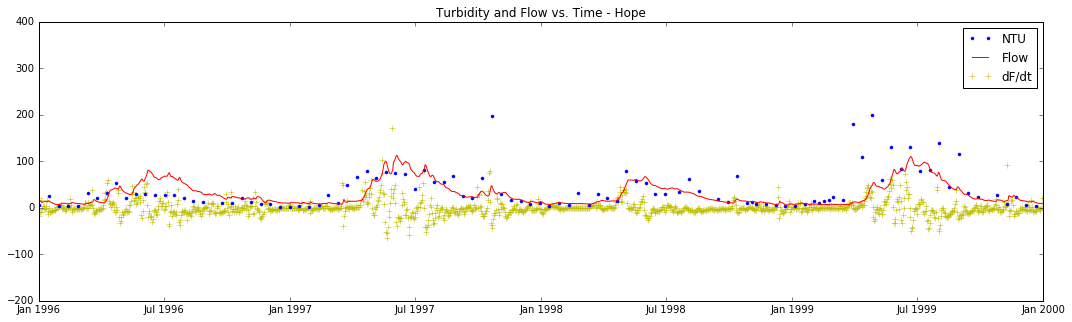

In [12]:
# plot flow and turbidity together
data=session.query(Profs.Year, Profs.Month, Profs.Day, Profs.value).\
            filter(and_(Profs.variable_name=='TURBIDITY',Profs.station_name.like('%Hope%'))).all()
Amm=[]
date=[]
for Y0, M0, D0, Amm0 in data:
    Amm.append(Amm0)
    date.append(dt.date(Y0,M0,D0))
AmmH=np.array(Amm)
dateH=np.array(date)

date=[]
fl=[]
daten0=[]
data2=session.query(Flow.Year,Flow.Month,Flow.Day,Flow.RateHope)
for row in data2.all():
    fl.append(row.RateHope)
    date.append(dt.date(row.Year,row.Month,row.Day))
    daten0.append((dt.date(row.Year,row.Month,row.Day)-dt.date(1900,1,1)).days)
FlowH=np.array(fl)
dateN=np.array(daten0)
dateF=np.array(date)
dFdt=np.diff(FlowH)/np.diff(dateN)
datedFdt=(dateF[:-1]-dateF[1:])/2+dateF[:-1]

plt.figure(figsize=(18,5))
Ft,=plt.plot(datedFdt, dFdt/10., 'y+',label='dF/dt')
tu,=plt.plot(dateH, AmmH, 'b.',label='NTU')
fl,=plt.plot(dateF, FlowH/10**2, 'r-',label='Flow')
plt.title('Turbidity and Flow vs. Time - Hope')
plt.xlim((dt.date(1996,1,1),dt.date(2000,1,1)))
plt.legend(handles=[tu,fl,Ft])

In [13]:
turHQRY=session.query(PDates.NDate.label('TDay'),Profs.value.label('Turb')).\
    select_from(Profs).join(PDates,PDates.ID==Profs.id).\
    filter(and_(Profs.variable_name=='TURBIDITY',
                Profs.station_name.like('%Hope%'))).subquery()


In [ ]:
tvals=np.arange(-60,60)
print(tvals)
Rs=0.0*tvals
R2s=Rs

for ii in range(0,len(tvals)):
    #print(tvals[ii])
    turHQRY=session.query((PDates.NDate-int(tvals[ii])).label('TDayShift'),PDates.NDate.label('TDay'),Profs.value.label('Turb')).\
        select_from(Profs).join(PDates,PDates.ID==Profs.id).filter(and_(Profs.variable_name=='TURBIDITY',
                Profs.station_name.like('%Hope%'))).subquery()
    matchesQRY=session.query(Flow.NDate.label('FDay'),turHQRY.c.TDay,Flow.RateHope,turHQRY.c.Turb).\
        select_from(turHQRY).join(Flow,Flow.NDate==turHQRY.c.TDayShift).group_by(Flow.NDate).order_by(Flow.NDate)
    #dl=matchesQRY.limit(30)
    #for row in dl:
    #    print(row)
    #flowMatch=session.query(turH.c.TurH,Flow.RateHope).select_from(turH).\
    #    join(Flow,(Flow.NDate-turH.c.Days)==tvals[ii]).filter(and_(Flow.RateHope>0.0,
    #                                                     turH.c.TurH>0.0))
    FD,TD,Fl,Tu=zip(*matchesQRY.all())
    R=np.corrcoef(np.array((Tu,Fl)))
    Rs[ii]=R[1,0]
    # calc dFdT and correlation:
    dFdt=np.diff(Fl)/np.diff(FD)
    TatdFdt=0.5*(np.array(Tu[:-1])+np.array(Tu[1:]))
    R2=np.corrcoef(np.array((TatdFdt,dFdt)))
    R2s[ii]=R2[1,0]
    #print(tvals[ii],matchesQRY.count(),R,np.array((Tu,Fl)).shape)
plt.figure(figsize=(16,5))
plt.plot(tvals, Rs, 'k*')
plt.plot(tvals, R2s, 'r*')

#plt.title('Correlation - Turbidity and Flow vs. Lag - Hope')
#plt.xlim((dt.date(1992,1,1),dt.date(2000,1,1)))

[-60 -59 -58 -57 -56 -55 -54 -53 -52 -51 -50 -49 -48 -47 -46 -45 -44 -43
 -42 -41 -40 -39 -38 -37 -36 -35 -34 -33 -32 -31 -30 -29 -28 -27 -26 -25
 -24 -23 -22 -21 -20 -19 -18 -17 -16 -15 -14 -13 -12 -11 -10  -9  -8  -7
  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5   6   7   8   9  10  11
  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59]


In [66]:
Rs

array([-0.22898287, -0.21371986, -0.20313908, -0.20043373, -0.1940704 ,
       -0.1883194 , -0.18780954, -0.17878173, -0.16117471, -0.14498741,
       -0.13439246, -0.12419219, -0.11230516, -0.10241447, -0.09547083,
       -0.08524042, -0.07633922, -0.06738018, -0.06152357, -0.06362333,
       -0.0657497 , -0.06658352, -0.06357372, -0.05534038, -0.04978686,
       -0.04155693, -0.03420968, -0.02804588, -0.02086379, -0.01004455,
        0.00238548,  0.01019179,  0.01540054,  0.02786643,  0.03679165,
        0.04078368,  0.04456117,  0.04980981,  0.05584989,  0.06227028,
        0.06568061,  0.06907591,  0.06319557,  0.05218949,  0.05372249,
        0.0685047 ,  0.09219335,  0.11495701,  0.13792592,  0.15645148,
        0.1743282 ,  0.19060053,  0.20188275,  0.20851691,  0.21704383,
        0.2184967 ,  0.22581394,  0.23849694,  0.24937593,  0.26027584,
        0.28502869,  0.30200089,  0.30692963,  0.30355523,  0.30036181,
        0.30666815,  0.31850394,  0.32739768,  0.33292466,  0.33

In [49]:
Rs

array([ 0.42807269,  0.43592905,  0.4430237 ,  0.45108046,  0.45913814,
        0.46174718,  0.46027709,  0.45772146,  0.4592537 ,  0.46682983,
        0.47459952,  0.48082167,  0.48635521,  0.49160828,  0.49540262,
        0.50024012,  0.50405459,  0.50411298,  0.50421591,  0.50318724,
        0.50523272,  0.5045355 ,  0.50097176,  0.49888102,  0.50152827,
        0.50502348,  0.50750339,  0.50818409,  0.50980913,  0.50995185,
        0.50980846,  0.51133401,  0.51353992,  0.51572326,  0.51779531,
        0.51918164,  0.5176961 ,  0.51564266,  0.51564378,  0.51634303,
        0.50985915,  0.50469621,  0.50593968,  0.50580966,  0.50116401,
        0.49493926,  0.49205882,  0.4873497 ,  0.48132742,  0.47712521,
        0.47408475,  0.47245677,  0.47243468,  0.47049775,  0.47124629,
        0.47055844,  0.47128497,  0.47044308,  0.46618272,  0.46131515,
        0.45494527,  0.44230696,  0.41946788,  0.39517733,  0.37441885,
        0.35567153,  0.33799401,  0.32476986,  0.31050684,  0.30

In [21]:
test=data2.all()

In [37]:
Year,Mon,Day,Rate=zip(*test)

In [38]:
Year

(1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,
 1912,

In [22]:
data=session.query(
    Profs.value).filter(and_(Profs.station_name.like('%Hope%'),
                                           Profs.variable_name=='TURBIDITY')).count()

In [23]:
print(data)

736


In [28]:
data=session.query(Profs.Year, Profs.Month, Profs.Day, Profs.value).\
            filter(and_(
                Profs.variable_name=='TURBIDITY',
                Profs.station_name=='Fraser River (Main Arm) at Gravesend Reach - Buoy')).all()
Y=[]
M=[]
D=[]
Amm=[]
date=[]
for Y0, M0, D0, Amm0 in data:
    Y.append(Y0)
    M.append(M0)
    D.append(D0)
    Amm.append(Amm0)
    date.append(dt.date(Y0,M0,D0))
Y=np.array(Y)
M=np.array(M)
D=np.array(D)
Amm1=np.array(Amm)
date1=np.array(date)

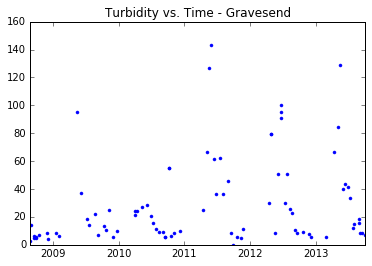

In [29]:
plt.plot(date1, Amm1, 'b.')
plt.title('Turbidity vs. Time - Gravesend')

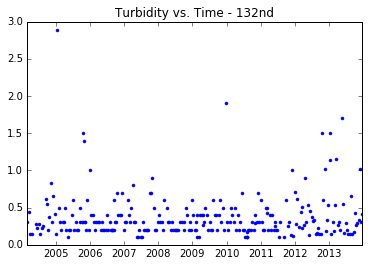

In [25]:
data=session.query(Profs.Year, Profs.Month, Profs.Day, Profs.value).\
            filter(and_(
                Profs.variable_name=='TURBIDITY',
                Profs.station_name.like('%132nd Ave and Edge Street%'))).all()
Y=[]
M=[]
D=[]
Amm=[]
date=[]
for Y0, M0, D0, Amm0 in data:
    Y.append(Y0)
    M.append(M0)
    D.append(D0)
    Amm.append(Amm0)
    date.append(dt.date(Y0,M0,D0))
Y=np.array(Y)
M=np.array(M)
D=np.array(D)
Amm=np.array(Amm)
date=np.array(date)
plt.plot(date, Amm, 'b.')
plt.title('Turbidity vs. Time - 132nd')

(733316.0, 735234.0)

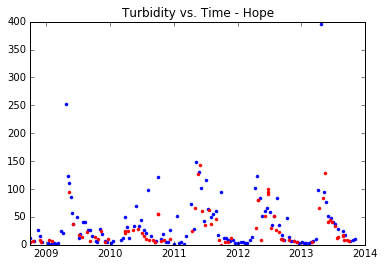

In [36]:
data=session.query(Profs.Year, Profs.Month, Profs.Day, Profs.value).\
            filter(and_(
                Profs.variable_name=='TURBIDITY',
                Profs.station_name.like('%Hope%'))).all()
Y=[]
M=[]
D=[]
Amm=[]
date=[]
for Y0, M0, D0, Amm0 in data:
    Y.append(Y0)
    M.append(M0)
    D.append(D0)
    Amm.append(Amm0)
    date.append(dt.date(Y0,M0,D0))
Y=np.array(Y)
M=np.array(M)
D=np.array(D)
Amm=np.array(Amm)
date=np.array(date)
plt.plot(date, Amm, 'b.')
plt.plot(date1, Amm1, 'r.')
plt.title('Turbidity vs. Time - Hope')
plt.xlim((dt.date(2008,10,1),dt.date(2014,1,1)))

In [27]:
date[-1]

datetime.date(2013, 11, 4)

In [8]:
data=session.query(Profs.station_name, Profs.unit_code, func.count()).\
            filter(Profs.variable_name=='AMMONIA DISSOLVED').group_by(Profs.unit_code,Profs.station_name).all()
for row in data:
    print(row)

('Chilcotin River upstream of Christie Road Bridge', 'MG/L', 189)
('Fraser River (Main Arm) at Gravesend Reach - Buoy', 'MG/L', 48)
('Fraser River at Hansard', 'MG/L', 3)
('Fraser River at Hope', 'MG/L', 4)
('Fraser River at Marguerite', 'MG/L', 7)
('Fraser River at Red Pass', 'MG/L', 1)
('Horsefly River above Quesnel Lake', 'MG/L', 168)
('Nechako River at Prince George', 'MG/L', 3)
('Nicola River near mouth at Thompson River', 'MG/L', 145)
('North Alouette River at 132nd Ave and Edge Street', 'MG/L', 3)
('Salmon River at Highway 1 Bridge', 'MG/L', 301)
('Shuswap River upstream Mara Lake', 'MG/L', 76)
('Thompson River at Spences Bridge', 'MG/L', 60)
('Chilcotin River upstream of Christie Road Bridge', 'UG/G', 1)
('Nicola River near mouth at Thompson River', 'UG/G', 1)


In [9]:
data=session.query(Profs.Year, Profs.Month, Profs.Day, Profs.value).\
            filter(and_(
                Profs.variable_name=='AMMONIA DISSOLVED',
                Profs.station_name=='Fraser River (Main Arm) at Gravesend Reach - Buoy')).all()

In [10]:
Y=[]
M=[]
D=[]
Amm=[]
date=[]
for Y0, M0, D0, Amm0 in data:
    Y.append(Y0)
    M.append(M0)
    D.append(D0)
    Amm.append(Amm0)
    date.append(dt.date(Y0,M0,D0))
Y=np.array(Y)
M=np.array(M)
D=np.array(D)
Amm=np.array(Amm)
date=np.array(date)

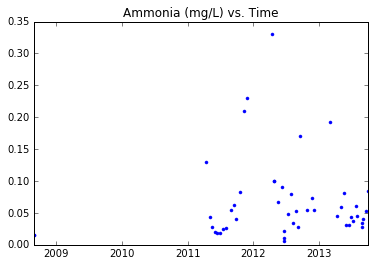

In [11]:
plt.plot(date, Amm, 'b.')
plt.title('Ammonia (mg/L) vs. Time')

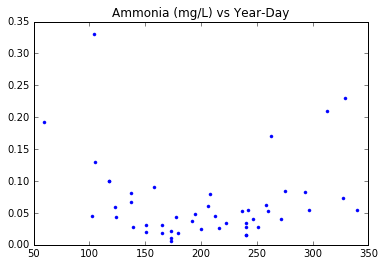

In [12]:
YD=0.0*Y
for i in range(0,len(Y)):
    YD[i]=date[i].timetuple().tm_yday
plt.plot(YD,Amm,'b.')
plt.title('Ammonia (mg/L) vs Year-Day')

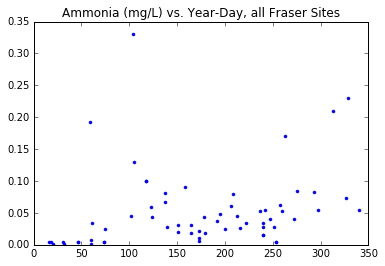

In [13]:
data=session.query(Profs.Year, Profs.Month, Profs.Day, Profs.value).\
            filter(Profs.variable_name=='AMMONIA DISSOLVED').\
            filter(Profs.station_name.like('Fraser River%')).all()
Y=[]; M=[]; D=[]; Amm=[]; date=[]
for Y0, M0, D0, Amm0 in data:
    Y.append(Y0)
    M.append(M0)
    D.append(D0)
    Amm.append(Amm0)
    date.append(dt.date(Y0,M0,D0))
Y=np.array(Y)
M=np.array(M)
D=np.array(D)
Amm=np.array(Amm)
date=np.array(date)
YD=0.0*Y
for i in range(0,len(Y)):
    YD[i]=date[i].timetuple().tm_yday
plt.plot(YD,Amm,'b.')
plt.title('Ammonia (mg/L) vs. Year-Day, all Fraser Sites')

3.29305606549 uM


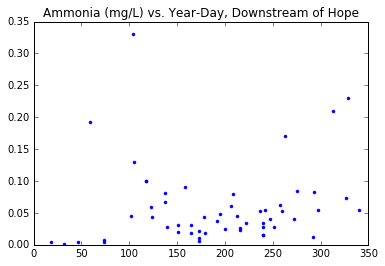

In [14]:

data=session.query(Profs.Year, Profs.Month, Profs.Day, Profs.value).\
            filter(Profs.variable_name=='AMMONIA DISSOLVED').\
            filter(or_(
                    Profs.station_name.like('%Hope%'),
                    Profs.station_name.like('%132nd Ave and Edge Street%'),
                    Profs.station_name.like('%Gravesend%'))).all()
Y=[]; M=[]; D=[]; Amm=[]; date=[]
for Y0, M0, D0, Amm0 in data:
    Y.append(Y0)
    M.append(M0)
    D.append(D0)
    Amm.append(Amm0)
    date.append(dt.date(Y0,M0,D0))
Y=np.array(Y)
M=np.array(M)
D=np.array(D)
Amm=np.array(Amm)
date=np.array(date)
YD=0.0*Y
for i in range(0,len(Y)):
    YD[i]=date[i].timetuple().tm_yday
plt.plot(YD,Amm,'b.')
plt.title('Ammonia (mg/L) vs. Year-Day, Downstream of Hope')
meanAmm_uM=np.mean(Amm)/18.038508*10**3 # divide by molecular weight of NH4 and convert mmol to umol
print(meanAmm_uM, 'uM')

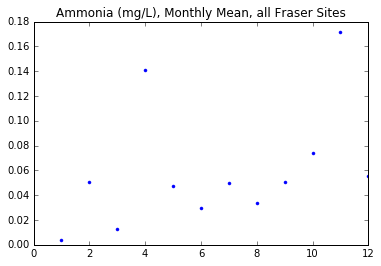

In [15]:
data=session.query(Profs.Month, func.avg(Profs.value)).\
            filter(Profs.variable_name=='AMMONIA DISSOLVED').\
            filter(Profs.station_name.like('Fraser River%')).group_by(Profs.Month).all()
M=[]
Amm=[]
for M0, Amm0 in data:
    M.append(M0)
    Amm.append(Amm0)
M=np.array(M)
Amm=np.array(Amm)
plt.plot(M,Amm,'b.')
plt.title('Ammonia (mg/L), Monthly Mean, all Fraser Sites')

# NITRATE+NITRITE

In [16]:
data=session.query(Profs.variable_name, Profs.station_name, Profs.unit_code, func.count()).\
            filter(or_(Profs.variable_name=='NITROGEN DISSOLVED NITRATE',
                      Profs.variable_name=='NITROGEN DISSOLVED NO3 & NO2')).\
            group_by(Profs.variable_name,Profs.unit_code,Profs.station_name).all()
for row in data:
    print(row)

('NITROGEN DISSOLVED NITRATE', 'Chilcotin River upstream of Christie Road Bridge', 'MG/L', 104)
('NITROGEN DISSOLVED NITRATE', 'Fraser River (Main Arm) at Gravesend Reach - Buoy', 'MG/L', 75)
('NITROGEN DISSOLVED NITRATE', 'Fraser River at Hansard', 'MG/L', 93)
('NITROGEN DISSOLVED NITRATE', 'Fraser River at Hargreaves Bridge', 'MG/L', 1)
('NITROGEN DISSOLVED NITRATE', 'Fraser River at Hope', 'MG/L', 236)
('NITROGEN DISSOLVED NITRATE', 'Fraser River at Marguerite', 'MG/L', 222)
('NITROGEN DISSOLVED NITRATE', 'Fraser River at Red Pass', 'MG/L', 219)
('NITROGEN DISSOLVED NITRATE', 'Horsefly River above Quesnel Lake', 'MG/L', 181)
('NITROGEN DISSOLVED NITRATE', 'Nechako River at Prince George', 'MG/L', 228)
('NITROGEN DISSOLVED NITRATE', 'Nicola River near mouth at Thompson River', 'MG/L', 63)
('NITROGEN DISSOLVED NITRATE', 'North Alouette River at 132nd Ave and Edge Street', 'MG/L', 128)
('NITROGEN DISSOLVED NITRATE', 'Salmon River at Highway 1 Bridge', 'MG/L', 219)
('NITROGEN DISSOLVED 

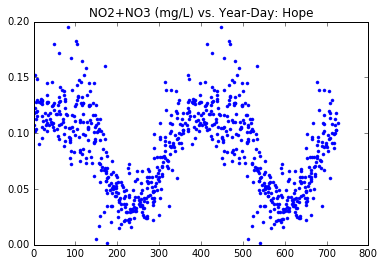

In [17]:
# NO2+NO3 at Hope
data=session.query(Profs.Year, Profs.Month, Profs.Day, Profs.value).\
            filter(and_(
                Profs.variable_name=='NITROGEN DISSOLVED NO3 & NO2',
                Profs.station_name=='Fraser River at Hope')).all()
Y=[]
M=[]
D=[]
Amm=[]
date=[]
for Y0, M0, D0, Amm0 in data:
    Y.append(Y0)
    M.append(M0)
    D.append(D0)
    Amm.append(Amm0)
    date.append(dt.date(Y0,M0,D0))
Y=np.array(Y)
M=np.array(M)
D=np.array(D)
Amm=np.array(Amm)
date=np.array(date)
YD=0.0*Y
for i in range(0,len(Y)):
    YD[i]=date[i].timetuple().tm_yday
plt.plot(YD,Amm,'b.')
plt.plot(YD+365.0,Amm,'b.')
plt.title('NO2+NO3 (mg/L) vs. Year-Day: Hope')

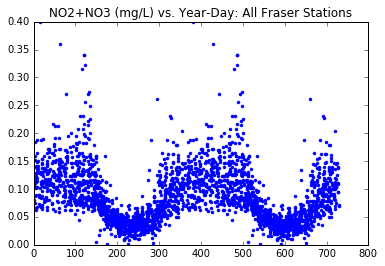

In [18]:
## NO2+NO3, all Fraser Stations:
data=session.query(Profs.Year, Profs.Month, Profs.Day, Profs.value).\
            filter(and_(
                Profs.value<2.5,#exlude 2 high points
                Profs.variable_name=='NITROGEN DISSOLVED NO3 & NO2',
                Profs.station_name.like('Fraser River%'))).all()
Y=[]
M=[]
D=[]
Amm=[]
date=[]
for Y0, M0, D0, Amm0 in data:
    Y.append(Y0)
    M.append(M0)
    D.append(D0)
    Amm.append(Amm0)
    date.append(dt.date(Y0,M0,D0))
Y=np.array(Y)
M=np.array(M)
D=np.array(D)
Amm=np.array(Amm)
date=np.array(date)
YD=0.0*Y
for i in range(0,len(Y)):
    YD[i]=date[i].timetuple().tm_yday
plt.plot(YD,Amm,'b.')
plt.plot(YD+365.0,Amm,'b.')
plt.title('NO2+NO3 (mg/L) vs. Year-Day: All Fraser Stations')

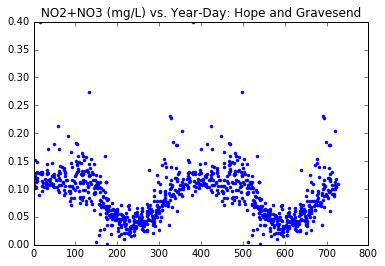

In [19]:
## NO2+NO3, all Fraser Stations:
data=session.query(Profs.Year, Profs.Month, Profs.Day, Profs.value).\
            filter(and_(
                Profs.value<2.5,#exlude 2 high points
                Profs.variable_name=='NITROGEN DISSOLVED NO3 & NO2',
                or_(
                    Profs.station_name.like('%Hope%'),
                    Profs.station_name.like('%Gravesend%')))).all()
Y=[]
M=[]
D=[]
Amm=[]
date=[]
for Y0, M0, D0, Amm0 in data:
    Y.append(Y0)
    M.append(M0)
    D.append(D0)
    Amm.append(Amm0)
    date.append(dt.date(Y0,M0,D0))
Y=np.array(Y)
M=np.array(M)
D=np.array(D)
Amm=np.array(Amm)
date=np.array(date)
YD=0.0*Y
for i in range(0,len(Y)):
    YD[i]=date[i].timetuple().tm_yday
plt.plot(YD,Amm,'b.')
plt.plot(YD+365.0,Amm,'b.')
plt.title('NO2+NO3 (mg/L) vs. Year-Day: Hope and Gravesend')



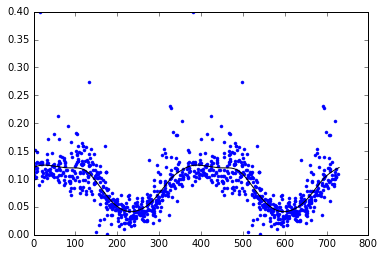

In [20]:
allt=np.arange(0,366)
fil=np.empty(np.size(allt))
L=50
s=L/2.355
for t in allt:
    diff=[min(abs(x-t),abs(x-t+365), abs(x-t-365)) for x in YD]
    weight=[np.exp(-.5*x**2/s**2) if x <= 3*L else 0.0 for x in diff]
    #weight=[np.exp(-.5*x**2/s**2) for x in diff]
    fil[t]=np.sum(weight*Amm)/np.sum(weight)
plt.plot(YD,Amm,'b.')
plt.plot(YD+365.0,Amm,'b.')
plt.plot(allt,fil,'k-')
plt.plot(allt+365,fil,'k-')
#plt.plot(YD,weight,'*')

# Dissolved Silica

In [21]:
data=session.query(Profs.latitude, Profs.longitude, Profs.variable_name, Profs.station_name, Profs.unit_code, func.count()).\
            filter(or_(Profs.variable_name=='SILICA DISSOLVED',
                      Profs.variable_name=='SILICON DISSOLVED')).\
            group_by(Profs.variable_name,Profs.unit_code,Profs.station_name).all()
for row in data:
    print(row)

(54.07706, -121.8484, 'SILICA DISSOLVED', 'Fraser River at Hansard', 'MG/L', 191)
(49.38722, -121.4508, 'SILICA DISSOLVED', 'Fraser River at Hope', 'MG/L', 220)
(52.52964, -122.44228, 'SILICA DISSOLVED', 'Fraser River at Marguerite', 'MG/L', 208)
(52.9878, -119.0101, 'SILICA DISSOLVED', 'Fraser River at Red Pass', 'MG/L', 240)
(53.92722, -122.765, 'SILICA DISSOLVED', 'Nechako River at Prince George', 'MG/L', 204)
(50.69139, -119.32889, 'SILICA DISSOLVED', 'Salmon River at Highway 1 Bridge', 'MG/L', 238)
(50.68056, -120.32444, 'SILICA DISSOLVED', 'South Thompson River at Kamloops', 'MG/L', 1)
(50.42083, -121.34139, 'SILICA DISSOLVED', 'Thompson River at Spences Bridge', 'MG/L', 212)
(49.167, -123.035, 'SILICON DISSOLVED', 'Fraser River (Main Arm) at Gravesend Reach - Buoy', 'MG/L', 14)
(53.92722, -122.765, 'SILICON DISSOLVED', 'Nechako River at Prince George', 'MG/L', 22)
(49.24211, -122.5961, 'SILICON DISSOLVED', 'North Alouette River at 132nd Ave and Edge Street', 'MG/L', 5)


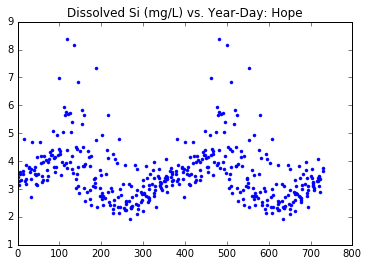

In [22]:
# Si at Hope
data=session.query(Profs.Year, Profs.Month, Profs.Day, Profs.value).\
            filter(or_(Profs.variable_name=='SILICA DISSOLVED',
                      Profs.variable_name=='SILICON DISSOLVED')).filter(
                Profs.station_name=='Fraser River at Hope').all()
Y=[]
M=[]
D=[]
Amm=[]
date=[]
for Y0, M0, D0, Amm0 in data:
    Y.append(Y0)
    M.append(M0)
    D.append(D0)
    Amm.append(Amm0)
    date.append(dt.date(Y0,M0,D0))
Y=np.array(Y)
M=np.array(M)
D=np.array(D)
Amm=np.array(Amm)
date=np.array(date)
YD=0.0*Y
for i in range(0,len(Y)):
    YD[i]=date[i].timetuple().tm_yday
plt.plot(YD,Amm,'b.')
plt.plot(YD+365.0,Amm,'b.')
plt.title('Dissolved Si (mg/L) vs. Year-Day: Hope')

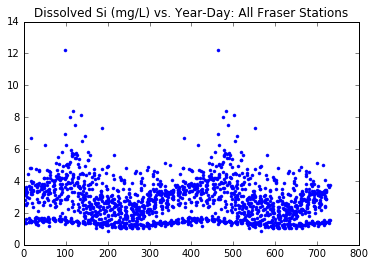

In [23]:
## Si, all Fraser Stations:
data=session.query(Profs.Year, Profs.Month, Profs.Day, Profs.value).\
            filter(or_(Profs.variable_name=='SILICA DISSOLVED',
                      Profs.variable_name=='SILICON DISSOLVED')).filter(
                Profs.station_name.like('Fraser River%')).all()
Y=[]
M=[]
D=[]
Amm=[]
date=[]
for Y0, M0, D0, Amm0 in data:
    Y.append(Y0)
    M.append(M0)
    D.append(D0)
    Amm.append(Amm0)
    date.append(dt.date(Y0,M0,D0))
Y=np.array(Y)
M=np.array(M)
D=np.array(D)
Amm=np.array(Amm)
date=np.array(date)
YD=0.0*Y
for i in range(0,len(Y)):
    YD[i]=date[i].timetuple().tm_yday
plt.plot(YD,Amm,'b.')
plt.plot(YD+365.0,Amm,'b.')
plt.title('Dissolved Si (mg/L) vs. Year-Day: All Fraser Stations')

In [24]:
data=session.query(Profs.station_name, func.avg(Profs.value)).\
            filter(or_(Profs.variable_name=='SILICA DISSOLVED',
                      Profs.variable_name=='SILICON DISSOLVED')).\
            group_by(Profs.station_name).all()
for row in data:
    print(row)

('Fraser River (Main Arm) at Gravesend Reach - Buoy', 2.3121428571428573)
('Fraser River at Hansard', 2.6484293193717274)
('Fraser River at Hope', 3.569227272727273)
('Fraser River at Marguerite', 3.338653846153846)
('Fraser River at Red Pass', 1.3941250000000003)
('Nechako River at Prince George', 2.984513274336285)
('North Alouette River at 132nd Ave and Edge Street', 1.388)
('Salmon River at Highway 1 Bridge', 11.404579831932779)
('South Thompson River at Kamloops', 2.93)
('Thompson River at Spences Bridge', 2.87617924528302)


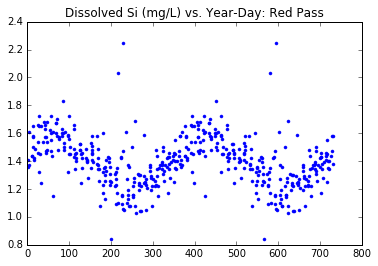

In [25]:
# Si at Red Pass
data=session.query(Profs.Year, Profs.Month, Profs.Day, Profs.value).\
            filter(or_(Profs.variable_name=='SILICA DISSOLVED',
                      Profs.variable_name=='SILICON DISSOLVED')).filter(
                Profs.station_name=='Fraser River at Red Pass').all()
Y=[]
M=[]
D=[]
Amm=[]
date=[]
for Y0, M0, D0, Amm0 in data:
    Y.append(Y0)
    M.append(M0)
    D.append(D0)
    Amm.append(Amm0)
    date.append(dt.date(Y0,M0,D0))
Y=np.array(Y)
M=np.array(M)
D=np.array(D)
Amm=np.array(Amm)
date=np.array(date)
YD=0.0*Y
for i in range(0,len(Y)):
    YD[i]=date[i].timetuple().tm_yday
plt.plot(YD,Amm,'b.')
plt.plot(YD+365.0,Amm,'b.')
plt.title('Dissolved Si (mg/L) vs. Year-Day: Red Pass')

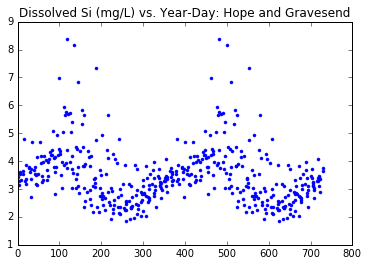

In [26]:
# Si at Hope or Gravesend
data=session.query(Profs.Year, Profs.Month, Profs.Day, Profs.value).\
            filter(or_(Profs.variable_name=='SILICA DISSOLVED',
                      Profs.variable_name=='SILICON DISSOLVED')).filter(
                  or_(
                    Profs.station_name.like('%Hope%'),
                    Profs.station_name.like('%Gravesend%'))).all()
Y=[]
M=[]
D=[]
Amm=[]
date=[]
for Y0, M0, D0, Amm0 in data:
    Y.append(Y0)
    M.append(M0)
    D.append(D0)
    Amm.append(Amm0)
    date.append(dt.date(Y0,M0,D0))
Y=np.array(Y)
M=np.array(M)
D=np.array(D)
Amm=np.array(Amm)
date=np.array(date)
YD=0.0*Y
for i in range(0,len(Y)):
    YD[i]=date[i].timetuple().tm_yday
plt.plot(YD,Amm,'b.')
plt.plot(YD+365.0,Amm,'b.')
plt.title('Dissolved Si (mg/L) vs. Year-Day: Hope and Gravesend')

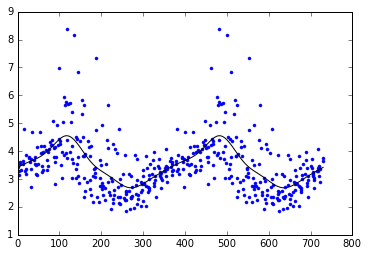

In [27]:
allt=np.arange(0,366)
fil=np.empty(np.size(allt))
L=50
s=L/2.355
for t in allt:
    diff=[min(abs(x-t),abs(x-t+365), abs(x-t-365)) for x in YD]
    weight=[np.exp(-.5*x**2/s**2) if x <= 3*L else 0.0 for x in diff]
    #weight=[np.exp(-.5*x**2/s**2) for x in diff]
    fil[t]=np.sum(weight*Amm)/np.sum(weight)
plt.plot(YD,Amm,'b.')
plt.plot(YD+365.0,Amm,'b.')
plt.plot(allt,fil,'k-')
plt.plot(allt+365,fil,'k-')
#plt.plot(YD,weight,'*')

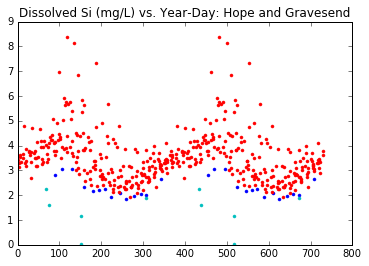

In [28]:
# show Si at Hope, Gravesend, and Alouette

data=session.query(Profs.Year, Profs.Month, Profs.Day, Profs.value).\
            filter(or_(Profs.variable_name=='SILICA DISSOLVED',
                      Profs.variable_name=='SILICON DISSOLVED')).filter(
                    Profs.station_name.like('%Gravesend%')).all()
Y=[]
M=[]
D=[]
Amm=[]
date=[]
for Y0, M0, D0, Amm0 in data:
    Y.append(Y0)
    M.append(M0)
    D.append(D0)
    Amm.append(Amm0)
    date.append(dt.date(Y0,M0,D0))
Y=np.array(Y)
M=np.array(M)
D=np.array(D)
Amm=np.array(Amm)
date=np.array(date)
YD=0.0*Y
for i in range(0,len(Y)):
    YD[i]=date[i].timetuple().tm_yday
plt.plot(YD,Amm,'b.')
plt.plot(YD+365.0,Amm,'b.')
plt.title('Dissolved Si (mg/L) vs. Year-Day: Hope and Gravesend')

data=session.query(Profs.Year, Profs.Month, Profs.Day, Profs.value).\
            filter(or_(Profs.variable_name=='SILICA DISSOLVED',
                      Profs.variable_name=='SILICON DISSOLVED')).filter(
                    Profs.station_name.like('%Hope%')).all()
Y=[]
M=[]
D=[]
Amm=[]
date=[]
for Y0, M0, D0, Amm0 in data:
    Y.append(Y0)
    M.append(M0)
    D.append(D0)
    Amm.append(Amm0)
    date.append(dt.date(Y0,M0,D0))
Y=np.array(Y)
M=np.array(M)
D=np.array(D)
Amm=np.array(Amm)
date=np.array(date)
YD=0.0*Y
for i in range(0,len(Y)):
    YD[i]=date[i].timetuple().tm_yday
plt.plot(YD,Amm,'r.')
plt.plot(YD+365.0,Amm,'r.')

data=session.query(Profs.Year, Profs.Month, Profs.Day, Profs.value).\
            filter(or_(Profs.variable_name=='SILICA DISSOLVED',
                      Profs.variable_name=='SILICON DISSOLVED')).filter(
                    Profs.station_name.like('%Alouette%')).all()
Y=[]
M=[]
D=[]
Amm=[]
date=[]
for Y0, M0, D0, Amm0 in data:
    Y.append(Y0)
    M.append(M0)
    D.append(D0)
    Amm.append(Amm0)
    date.append(dt.date(Y0,M0,D0))
Y=np.array(Y)
M=np.array(M)
D=np.array(D)
Amm=np.array(Amm)
date=np.array(date)
YD=0.0*Y
for i in range(0,len(Y)):
    YD[i]=date[i].timetuple().tm_yday
plt.plot(YD,Amm,'c.')
plt.plot(YD+365.0,Amm,'c.')

In [ ]:
'NITROGEN DISSOLVED ORGANIC (CALCD.)',)
('NITROGEN NITRITE',)
('NITROGEN TOTAL',)
('NITROGEN TOTAL DISSOLVED',)
('NITROGEN TOTAL KJELDAHL',)
('NITROGEN TOTAL ORGANIC (CALCD.)',)

Dissolved 0.24 MG/L
Dissolved 0.24 MG/L
Total 0.24 MG/L


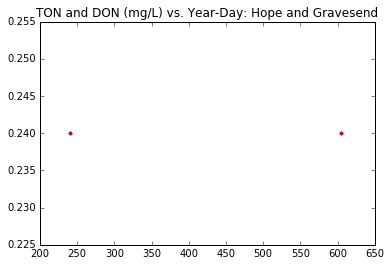

In [34]:
# DON at Hope or Gravesend
data=session.query(Profs.Year, Profs.Month, Profs.Day, Profs.value, Profs.unit_code).\
            filter(Profs.variable_name=='NITROGEN DISSOLVED ORGANIC (CALCD.)'
                      ).filter(
                  or_(
                    Profs.station_name.like('%Hope%'),
                    Profs.station_name.like('%Gravesend%'))).all()
Y=[]
M=[]
D=[]
Amm=[]
date=[]
for Y0, M0, D0, Amm0, u in data:
    Y.append(Y0)
    M.append(M0)
    D.append(D0)
    Amm.append(Amm0)
    date.append(dt.date(Y0,M0,D0))
    print('Dissolved',Amm0, u)
Y=np.array(Y)
M=np.array(M)
D=np.array(D)
Amm=np.array(Amm)
date=np.array(date)
YD=0.0*Y
for i in range(0,len(Y)):
    YD[i]=date[i].timetuple().tm_yday
plt.plot(YD,Amm,'b.')
plt.plot(YD+365.0,Amm,'b.')
plt.title('DON (mg/L) vs. Year-Day: Hope and Gravesend')

# TON at Hope or Gravesend
data=session.query(Profs.Year, Profs.Month, Profs.Day, Profs.value, Profs.unit_code).\
            filter(Profs.variable_name=='NITROGEN TOTAL ORGANIC (CALCD.)'
                      ).filter(
                  or_(
                    Profs.station_name.like('%Hope%'),
                    Profs.station_name.like('%Gravesend%'))).all()
Y=[]
M=[]
D=[]
Amm=[]
date=[]
for Y0, M0, D0, Amm0, u in data:
    Y.append(Y0)
    M.append(M0)
    D.append(D0)
    Amm.append(Amm0)
    date.append(dt.date(Y0,M0,D0))
    print('Total',Amm0, u)
Y=np.array(Y)
M=np.array(M)
D=np.array(D)
Amm=np.array(Amm)
date=np.array(date)
YD=0.0*Y
for i in range(0,len(Y)):
    YD[i]=date[i].timetuple().tm_yday
plt.plot(YD,Amm,'r.')
plt.plot(YD+365.0,Amm,'r.')
plt.title('TON and DON (mg/L) vs. Year-Day: Hope and Gravesend')

In [12]:
session.close()
engine.dispose()